# semantic segmentation unet

## data download

In [3]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2020-10-29 14:01:16--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.16
접속 s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.16|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M   130KB/s    in 41m 8s  

2020-10-29 14:42:26 (130 KB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



## data loader

In [7]:
### library install
!pip install albumentations

     |████████████████████████████████| 70 kB 454 kB/s eta 0:00:011
     |████████████████████████████████| 36.7 MB 9.0 MB/s eta 0:00:01


## library import

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


In [2]:
## Albumentation 사용 ex

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

# agument 
# 테스트 데이터는 리사이즈만 실행.

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

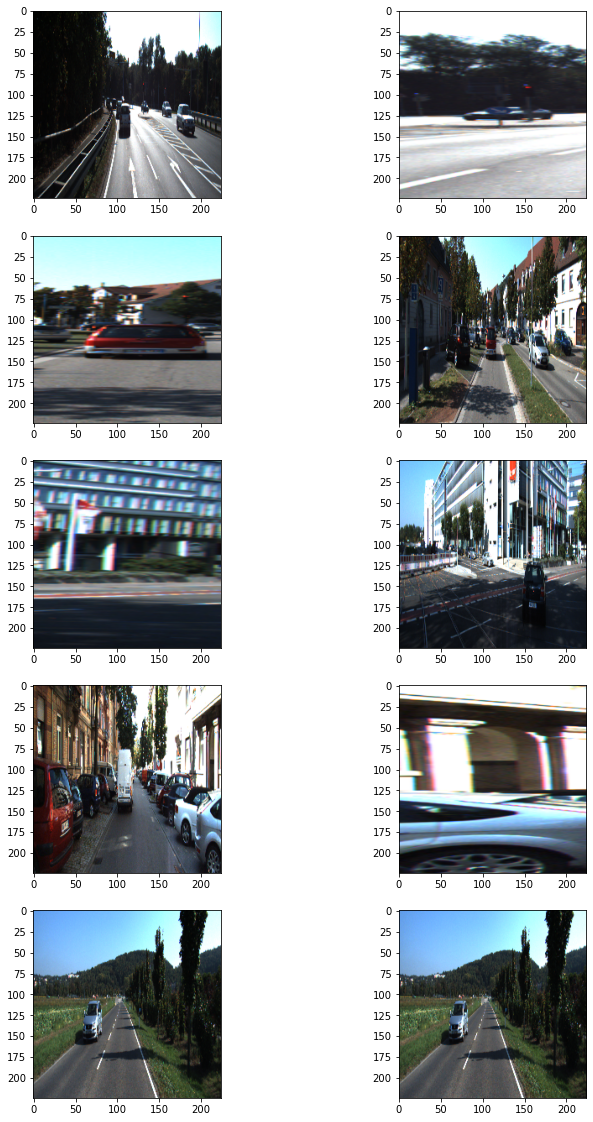

In [4]:
import os

dir_path = os.getenv('HOME')+'/aiffel//AIFFEL_LSG/utill/data_semantics/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [5]:
# tf.keras.utils.Sequence를 상속받은 generator

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [7]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
    
#train_data ...
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

# test date
test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## model define

![](https://miro.medium.com/max/700/1*qNdglJ1ORP3Gq77MmBLhHQ.png)

```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```

```


In [8]:
# ## model 구조만들기 ㅕ-net
# def build_model(input_shape=(224, 224, 3)):
#     model = None
#     # TODO: input_shape에 따라 U-Net을 만들어주세요
#     # 이때 model은 fully convolutional해야하합니다.
    
#     x= input(input_shape) 
 
    
#     #conv2
#     x = Conv2D(64,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
#     x = Conv2D(64,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
#     #downsampling
#     MaxPolling2D(pool_size=(2,2))(x) # 2x2 2플라이즈.
    
#     #conv2
#     x = Conv2D(128,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
#     x = Conv2D(128,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
#     #downsampling
#     MaxPolling2D(pool_size=(2,2))(x) # 2x2 2플라이즈.
    
#     x = Conv2D(256,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
#     x = Conv2D(256,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
#     #downsampling
#     MaxPolling2D(pool_size=(2,2))(x) # 2x2 2플라이즈.    
    
#     x = Conv2D(512,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
#     x = Conv2D(512,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
#     x= Dropout(0.5)(x)
#     #downsampling
#     MaxPolling2D(pool_size=(2,2))(x) # 2x2 2플라이즈.    
    
#     #x= Dropout(0.5)(x) #????????????????/
    
#     #################################################################################################
#     x = Conv2D(1024, 3, activation='relu', padding='same',kernel_initialize="he_normal")(x)
#     x = Conv2D(1024, 3, activation='relu', padding='same',kernel_initialize="he_normal")(x)
    
#     #x= Dropout(0.5)(x)
#     ###############################################################################################3
#     #up conv 2x2
#     x = Conv2D(512,2 activation="relu")
    
#     x = Conv2D(512,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
#     x = Conv2D(512,3,activation = 'relu',padding='same', kernel_initializer="he_normal")(x))
    
#      #up conv 2x2
    
#     x = Conv2D(256, 3, activation='relu', padding='same',kernel_initialize="he_normal")(x)
#     x = Conv2D(256, 3, activation='relu', padding='same',kernel_initialize="he_normal")(x)
    
#     # upcoonv 2x2 2
    
#     x = Conv2D(128, 3, activation='relu', padding='same',kernel_initialize="he_normal")(x)
#     x = Conv2D(128, 3, activation='relu', padding='same',kernel_initialize="he_normal")(x)
    
#     # upcoonv 2x2 2    
    
#     x = Conv2D(64, 3, activation='relu', padding='same',kernel_initialize="he_normal")(
  inputs = Input(input_shape)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='sax)
#     x = Conv2D(64, 3, activation='relu', padding='same',kernel_initialize="he_normal")(x)
    
#       # upcoonv 2x2 2     

#     model = Model(inputs = x, outputs = conv10)
#     return model

IndentationError: unexpected indent (<ipython-input-8-7bbd0c5fe9cd>, line 60)

In [9]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

  drop5 = Dropout(0.5)(conv5)

################################################################################################

  up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

  up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

  up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

## model train

In [10]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
11/11 [==============================] - 7s 607ms/step - loss: 0.6838 - val_loss: 0.6674
Epoch 2/100
11/11 [==============================] - 7s 632ms/step - loss: 0.3346 - val_loss: 0.0447
Epoch 3/100
11/11 [==============================] - 7s 626ms/step - loss: 0.0330 - val_loss: 0.0336
Epoch 4/100
11/11 [==============================] - 7s 628ms/step - loss: 0.0282 - val_loss: 0.0290
Epoch 5/100
11/11 [==============================] - 7s 625ms/step - loss: 0.0247 - val_loss: 0.0312
Epoch 6/100
11/11 [==============================] - 7s 627ms/step - loss: 0.0219 - val_loss: 0.0234
Epoch 7/100
11/11 [==============================] - 7s 626ms/step - loss: 0.0203 - val_loss: 0.0252
Epoch 8/100
11/11 [==============================] - 7s 628ms/step - loss: 0.0173 - val_loss: 0.0184
Epoch 9/100
11/11 [==============================] - 7s 622ms/step - loss: 0.0215 - val_loss: 0.0228
Epoch 10/100
11

## model 시각화

In [11]:
def get_output(model, preproc, image_path, output_path):
    # TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.
    
    ## 1.이미지 패스 이미지 읽기
    #img = imread(image_path)
    ## 2.model 올려서 나온 결과 뿌리기
    ## 3. output path 에 저정하기
    

    origin_img = imread(image_path)

    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()


    # 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
    i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
    get_output(
    model, 
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
    )
    return output



In [12]:
## iou 평가

def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [13]:
#???


def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [14]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.549576


0.5495763082030226

In [15]:
dir_path

'/home/aiffel0042/aiffel//AIFFEL_LSG/utill/data_semantics/training'

# 프로젝트- U-net++ model

## kitti data set 수집 구축
- batch size 4로 변경

In [16]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
    batch_size=4, #### batch size 변경
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## U-net ++ model 구현

### model define
![](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-5-P-UNPP.max-800x600.png)
 - https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20
 
- H where H() is a convolution operation followed by an activation function, U() denotes an up-sampling layer, and [ ] denotes the concatenation layer.

In [ ]:
# 구조 그려보기
def down_sampling(x): # ↘
    return x

def up_sampling(x): # ↗ # U인듯.
    return x

def skip_connenction(i,j):
    print(i,j)
    connect_list = []
    for k in range(j):
        print(k)
        connect_list.append(x[i][k])
    return connect_list
#skip_connenction(0,3)

def H(s_connect_list, up): #dense cov 
    return 4;

x = [[0,0,0,0,0],
     [0,0,0,0],
     [0,0,0],
     [0,0],
     [0]]

x[0][0] = 1 # input

#backbone
for i in range(1,5):
    x[i][0]= up_sampling(x[i-1][0])

# 나머지 라인
for j in range(1,5):
    for i in range(0,4-j+1):
        s_c_list = skip_connenction(i,j)
        x[i][j] = H(s_c_list, up_sampling(x[i+1][j-1])) ##
# 
x

In [ ]:
def build_model_uplus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    ################################################################
    # backbone

    # x 0,0 
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    #conv1 = BatchNormalization()(conv)
    
    # donwsampling. -1
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # x-  1,0
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    #conv2 = BatchNormalization()(conv2)
    
    # donwsampling -2 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # x- 2,0
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    #conv3 = BatchNormalization()(conv3)
    
    # downsampling -3
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # x - 3,0
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    #conv4 = BatchNormalization()(conv3)
  #drop4 = Dropout(0.5)(conv4)
    # downsampling -4
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # x -4.0
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)  
    #conv5 = BatchNormalization()(conv5)
    
    
    ######################################################################################
    
    
    ## x- 0,1
    # upsamping -1
    up1 = UpSampling2D(size = (2,2))(conv2)
    
    #skip -1
    # resize conv2 128 conv1 64
    # copy and crop
    
    skip1 = con1
    
    
    # x - 3.1  conv5-up, conv4-down => concat
    
    conv6= 
   up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

  up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    
    
    

In [19]:
def build_model_uplus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path(Backbone)
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    
    # Re-designed skip pathways
    # conv1_1, conv2_1, conv3_1
    up_conv2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2.shape[1], up_conv2.shape[2]))
    merge1_1 = concatenate([skip_crop_conv1, up_conv2])
    conv1_1 = conv_batch(merge1_1, 64)
    
    up_conv3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3.shape[1], up_conv3.shape[2]))
    merge2_1 = concatenate([skip_crop_conv2 , up_conv3])
    conv2_1 = conv_batch(merge2_1, 128)
    
    up_conv4 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4))
    skip_crop_conv3 = tf.image.resize(conv3, (up_conv4.shape[1], up_conv4.shape[2]))
    merge3_1 = concatenate([skip_crop_conv3, up_conv4])
    conv3_1 = conv_batch(merge3_1, 256)
    
    # conv1_2, conv2_2
    up_conv2_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    merge1_2 = concatenate([skip_crop_conv1, skip_crop_conv1_1, up_conv2_1])
    conv1_2 = conv_batch(merge1_2, 64)
    
    up_conv3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    skip_crop_conv2_1 = tf.image.resize(conv2_1, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    merge2_2 = concatenate([skip_crop_conv2, skip_crop_conv2_1, up_conv3_1])
    conv2_2 = conv_batch(merge2_2, 256)

    # conv1_3
    up_conv2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_2 = tf.image.resize(conv1_2, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    merge1_3 = concatenate([skip_crop_conv1, skip_crop_conv1_1, skip_crop_conv1_2, up_conv2_2])
    conv1_3 = conv_batch(merge1_3, 64)
    
    
    # Expansive path
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    crop_conv3_1 = tf.image.resize(conv3_1, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3, crop_conv3_1, up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    crop_conv2_1 = tf.image.resize(conv2_1, (up3.shape[1], up3.shape[2]))
    crop_conv2_2 = tf.image.resize(conv2_2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2, crop_conv2_1, crop_conv2_2, up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    crop_conv1_1 = tf.image.resize(conv1_1, (up4.shape[1], up4.shape[2]))
    crop_conv1_2 = tf.image.resize(conv1_2, (up4.shape[1], up4.shape[2]))
    crop_conv1_3 = tf.image.resize(conv1_3, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, crop_conv1_1, crop_conv1_2, crop_conv1_3, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [ ]:
def build_model_uplus(input_shape=(224, 224, 3)):
    pass

In [21]:
def conv_batch(layer, filters):
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(layer)
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv)
    batch = BatchNormalization()(conv)
    
    return batch

### mode train save

In [22]:
model_u_plus = build_model_uplus()
model_u_plus.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_u_plus.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

upluse_model_path = dir_path + '/seg_model_unet_plus.h5'
model_u_plus.save(upluse_model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 31s 729ms/step - loss: 0.7679 - val_loss: 0.6921
Epoch 2/100
43/43 [==============================] - 12s 273ms/step - loss: 0.7009 - val_loss: 0.6922
Epoch 3/100
43/43 [==============================] - 12s 273ms/step - loss: 0.6899 - val_loss: 0.6926
Epoch 4/100
43/43 [==============================] - 12s 271ms/step - loss: 0.6806 - val_loss: 0.6916
Epoch 5/100
43/43 [==============================] - 12s 281ms/step - loss: 0.6736 - val_loss: 0.6937
Epoch 6/100
43/43 [==============================] - 12s 289ms/step - loss: 0.6734 - val_loss: 0.6868
Epoch 7/100
43/43 [==============================] - 12s 287ms/step - loss: 0.6753 - val_loss: 0.6846
Epoch 8/100
43/43 [==============================] - 12s 274ms/step - loss: 0.6715 - val_loss: 0.6814
Epoch 9/100
43/43 [==============================] - 12s 283ms/step - loss: 0.6634 - val_loss: 0.7083
Epoch 10/100
43/43 [==============================] - 12s 269ms/step - loss: 0.666

## 시각화 및 결과 분석

In [46]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_u_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.649807


0.6498065229408513

In [23]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 4    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_u_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.689379


0.6893787575150301

##
![](./result.png)